In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
data = pd.read_excel('Analysis sheet-Indxx 500 Index~INXT Final.xlsx')
sofr_data = pd.read_excel('SOFR.xlsx')
print(data.head())
print(sofr_data.head())


  Ticker       date    value  Rebase value  Rebase value 60D
0   INXT 2005-04-29  1000.00           NaN               NaN
1   INXT 2005-05-02  1004.63           NaN               NaN
2   INXT 2005-05-03  1003.69           NaN               NaN
3   INXT 2005-05-04  1016.29           NaN               NaN
4   INXT 2005-05-05  1014.37           NaN               NaN
  observation_date  SOFR
0       2018-04-03  1.83
1       2018-04-04  1.74
2       2018-04-05  1.75
3       2018-04-06  1.75
4       2018-04-09  1.75


/var/folders/00/v04xmy7s6rvgzr8s5xfhqc6h0000gn/T/ipykernel_40177/694934179.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_data['SOFR'] = final_data['SOFR'].fillna(method='ffill')


Shape of data before analysis: (1913, 12)
Columns with null values: Date                    0
Indxx_500              60
Risk_Control_Index     60
Actual_Exposure        60
Historic_Volatility    60
Target_Exposure        60
SOFR                   41
Daily_Return            1
Log_Return              1
Vol_20d                20
Vol_60d                60
SOFR_Daily_Rate        41
dtype: int64
Infinity values: Indxx_500              0
Risk_Control_Index     0
Actual_Exposure        0
Historic_Volatility    0
Target_Exposure        0
SOFR                   0
Daily_Return           0
Log_Return             0
Vol_20d                0
Vol_60d                0
SOFR_Daily_Rate        0
dtype: int64


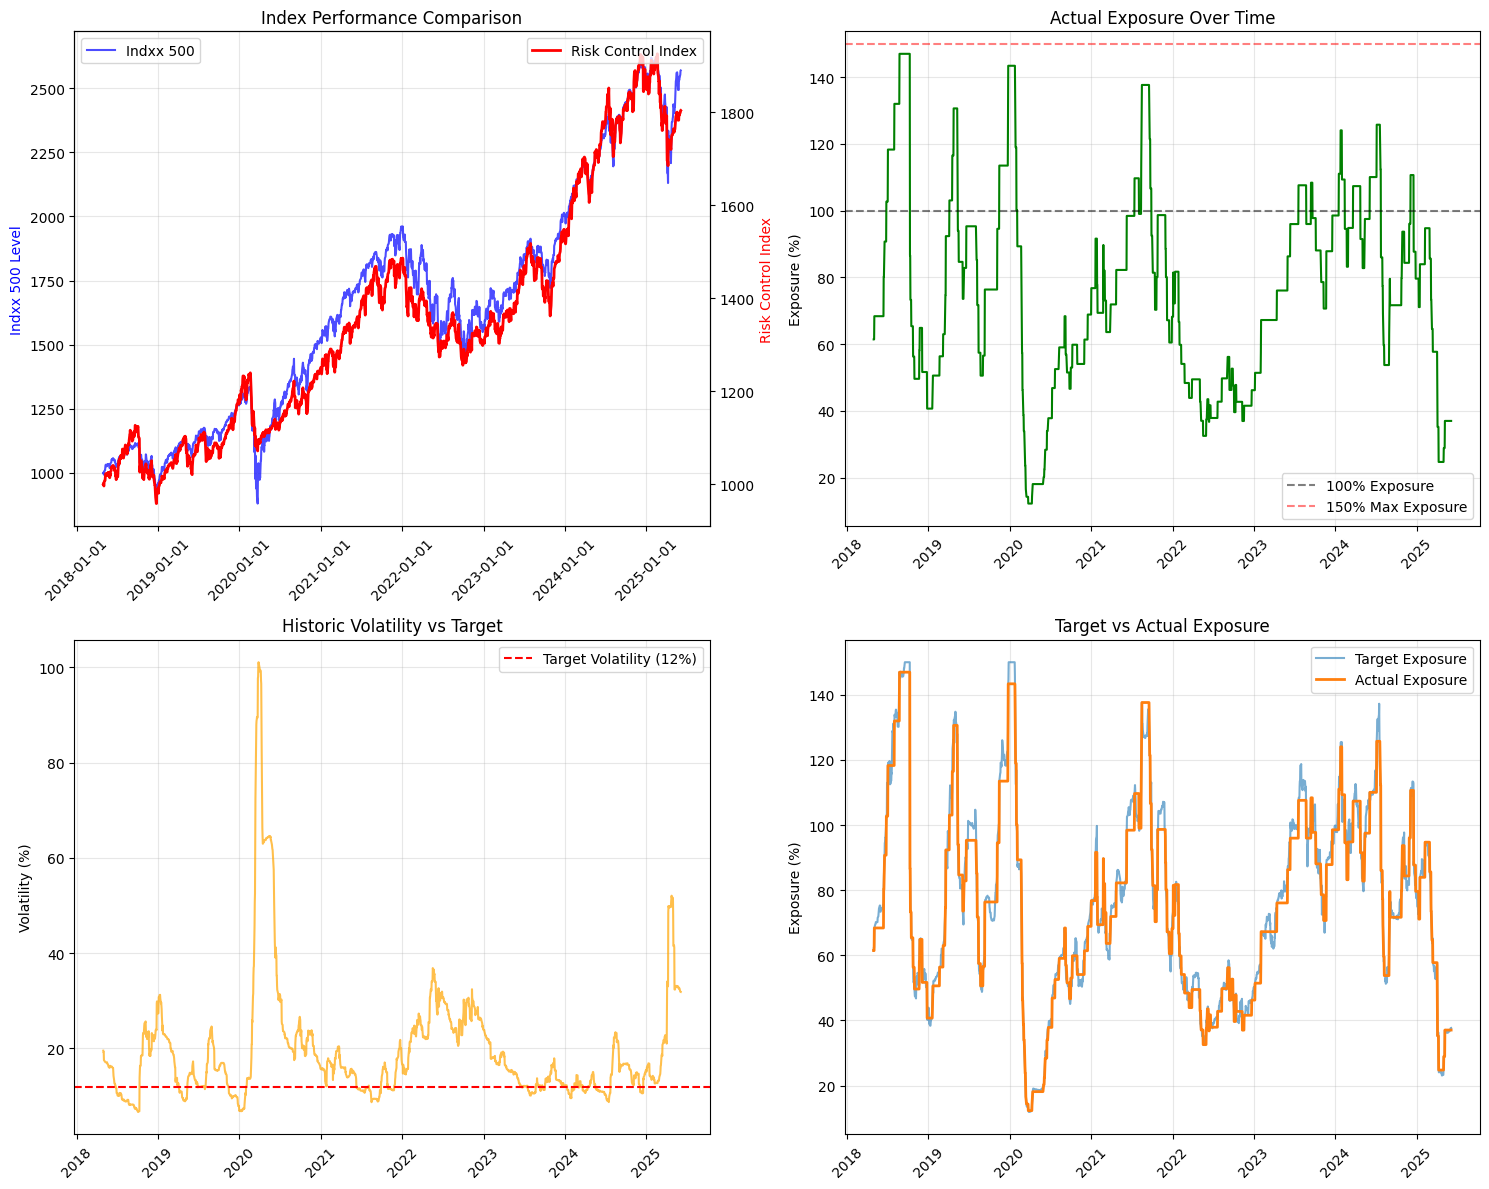

Date column type before export: datetime64[ns]
Sample dates before export: 60   2018-04-30
61   2018-05-01
62   2018-05-02
63   2018-05-03
64   2018-05-04
Name: Date, dtype: datetime64[ns]
Sample dates after formatting: 60    2018-04-30
61    2018-05-01
62    2018-05-02
63    2018-05-03
64    2018-05-04
Name: Date, dtype: object
Results successfully exported to Risk_Control_Index_Results.xlsx


In [3]:
def risk_control_index():
    try:
        data = pd.read_excel('Analysis sheet-Indxx 500 Index~INXT Final.xlsx', sheet_name = 'Analysis sheet-Indxx 500 Index~', parse_dates=['date'])
        data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y', errors='coerce')
        data = data.dropna(subset=['Rebase value 60D']) # Dropping rows where 'Rebase value' is NaN
        data = data.rename(columns={'Rebase value 60D': 'index_value'})
        data = data.rename(columns={'Rebase value': 'required_value'})
        data = data.sort_values('date').reset_index(drop=True)
    except FileNotFoundError as e:
        print(f"Error | The requested file was not found or couldn't be processed: {e}")
        return None
    
    try:
        sofr_data = pd.read_excel('SOFR.xlsx', parse_dates=['observation_date'])
        sofr_data['observation_date'] = pd.to_datetime(sofr_data['observation_date'])
        sofr_data = sofr_data.sort_values('observation_date').reset_index(drop=True)
        sofr_data['SOFR'] = sofr_data['SOFR'].ffill()
        sofr_data = sofr_data.rename(columns={'observation_date': 'date'})
    except FileNotFoundError as e:
        print(f"Error | The requested file was not found or couldn't be processed: {e}")
        return None
    
    target_volatility = .12 #12% Target volatility
    maximum_exposure = 1.5 #150% Maximum Exposure
    allowance = .1 #10% Allowance for volatility
    initial_value = 1000 #Initial value of the index

    #Calculating Daily Returns for the given index/data
    data['daily_return'] = data['index_value'].pct_change()
    data['log_return'] = np.log(data['index_value']/data['index_value'].shift(1))
    data['volume_20d'] = data['log_return'].rolling(window=20).std() * np.sqrt(252*20/19)
    data['volume_60d'] = data['log_return'].rolling(window=60).std() * np.sqrt(252*60/59)

    #Calculating Historic Volatility & Target Exposure
    data['historic_volatility'] = np.maximum(data['volume_20d'], data['volume_60d'])
    data['target_exposure'] = np.minimum(maximum_exposure, (target_volatility/data['historic_volatility']))

    if data.empty or sofr_data.empty:
        print("Error | Input dataframes are empty before calculations in risk_control_index.")
        return None
    try: 
        
        final_data = pd.merge(data, sofr_data[['date', 'SOFR']], on='date', how='left')
        final_data['SOFR'] = final_data['SOFR'].fillna(method='ffill')

        #Converting SOFR given to a daily rate
        final_data['sofr_daily_rate']  = (final_data['SOFR']/100)/365
        final_data['actual_exposure'] = np.nan

        first_valid_index = final_data['target_exposure'].first_valid_index()
        if first_valid_index is None:
            print(f"Error | No valid data found for the target exposure.")
            return None
        
        final_data.loc[first_valid_index, 'actual_exposure'] = final_data.loc[first_valid_index, 'target_exposure']

        for i in range(first_valid_index+1, len(final_data)):
            if pd.isna(final_data.loc[i, 'target_exposure']):
                final_data.loc[i, 'actual_exposure'] = final_data.loc[i-1, 'actual_exposure']
                
            previous_exposure = final_data.loc[i-1, 'actual_exposure']
            target_exposure = final_data.loc[i, 'target_exposure']

            if pd.notna(previous_exposure) and pd.notna(target_exposure):
                upper = target_exposure*(1+allowance)
                lower = target_exposure*(1-allowance)
                if previous_exposure > upper or previous_exposure < lower:
                    final_data.loc[i, 'actual_exposure'] = target_exposure
                else:
                    final_data.loc[i, 'actual_exposure'] = previous_exposure    
            else:
                final_data.loc[i, 'actual_exposure'] = target_exposure

        final_data['risk_control_index'] = np.nan
        final_data.loc[first_valid_index, 'risk_control_index'] = initial_value
        
        for i in range(first_valid_index+1, len(final_data)):
            if pd.isna(final_data.loc[i, 'actual_exposure']) or pd.isna(final_data.loc[i, 'daily_return']):
                final_data.loc[i, 'risk_control_index'] = final_data.loc[i-1, 'risk_control_index']

            previous_index = final_data.loc[i-1, 'risk_control_index']
            previous_exposure = final_data.loc[i-1, 'actual_exposure']
            equity_return = final_data.loc[i, 'daily_return']
            cash_return = final_data.loc[i, 'sofr_daily_rate']

            if pd.notna(previous_exposure):
                total_return_value = ((previous_exposure * equity_return)+ (1 - previous_exposure) * cash_return)
                final_data.loc[i, 'risk_control_index'] = previous_index * (1 + total_return_value)
            else:
                final_data.loc[i, 'risk_control_index'] = previous_index

        if final_data.empty:
            print("Error | final_data is empty after calculations in risk_control_index.")
            return None
        if final_data.isnull().all().all():
            print("Error | final_data contains all NaN values after calculations.")
            return None

        final_data['SOFR'] = final_data['SOFR'].ffill() 

        # return final_data
        output = final_data[['date', 
                    # 'index_value',
                    'required_value',
                    'risk_control_index', 
                    'actual_exposure', 
                    'historic_volatility', 
                    'target_exposure', 
                    'SOFR',
                    'daily_return', 
                    'log_return', 
                    'volume_20d', 
                    'volume_60d', 
                    'sofr_daily_rate']] 
        output.columns = ['Date',
                  'Indxx_500',
                  'Risk_Control_Index',
                  'Actual_Exposure',
                  'Historic_Volatility',
                  'Target_Exposure',
                  'SOFR',
                  'Daily_Return',
                  'Log_Return',
                  'Vol_20d',
                  'Vol_60d',
                  'SOFR_Daily_Rate']
        return output
    
    except Exception as e:
        print(f"Error | An error occurred during risk control index calculation: {e}")
        return None


def result_analysis(final_data):
    if final_data is None or final_data.empty:
        print("Error | No results to analyze in result_analysis.")
        return None

    print("Shape of data before analysis:", final_data.shape)
    print("Columns with null values:", final_data.isnull().sum())
    
    data_for_analysis = final_data.copy()
    data_for_analysis['Date'] = pd.to_datetime(data_for_analysis['Date'])
    
    # Check for any infinity values
    print("Infinity values:", np.isinf(data_for_analysis.select_dtypes(include=np.number)).sum())
    
    data_for_analysis = data_for_analysis.dropna(subset=['Indxx_500', 'Risk_Control_Index', 'Actual_Exposure', 'Historic_Volatility', 'Target_Exposure'])
    if data_for_analysis.empty:
        print("Warning: No data available for analysis after filtering.")
        return

    #Creating Vizualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Format dates for x-axis
    date_format = mdates.DateFormatter('%Y-%m-%d')

    # Plot 1: Index Performance Comparison
    ax1.xaxis.set_major_formatter(date_format)
    ax1.plot(data_for_analysis['Date'], data_for_analysis['Indxx_500'], label='Indxx 500', color='blue', alpha=0.7)
    ax1_twin = ax1.twinx()
    ax1_twin.plot(data_for_analysis['Date'], data_for_analysis['Risk_Control_Index'], label='Risk Control Index', color='red', linewidth=2)
    ax1.set_title('Index Performance Comparison')
    ax1.set_ylabel('Indxx 500 Level', color='blue')
    ax1_twin.set_ylabel('Risk Control Index', color='red')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Exposure Over Time
    ax2.plot(data_for_analysis['Date'], data_for_analysis['Actual_Exposure'] * 100, color='green', linewidth=1.5)
    ax2.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='100% Exposure')
    ax2.axhline(y=150, color='red', linestyle='--', alpha=0.5, label='150% Max Exposure')
    ax2.set_title('Actual Exposure Over Time')
    ax2.set_ylabel('Exposure (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Historic Volatility
    ax3.plot(data_for_analysis['Date'], data_for_analysis['Historic_Volatility'] * 100, color='orange', alpha=0.7)
    ax3.axhline(y=12, color='red', linestyle='--', label='Target Volatility (12%)')
    ax3.set_title('Historic Volatility vs Target')
    ax3.set_ylabel('Volatility (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Target vs Actual Exposure
    ax4.plot(data_for_analysis['Date'], data_for_analysis['Target_Exposure'] * 100, label='Target Exposure', alpha=0.6)
    ax4.plot(data_for_analysis['Date'], data_for_analysis['Actual_Exposure'] * 100, label='Actual Exposure', linewidth=2)
    ax4.set_title('Target vs Actual Exposure')
    ax4.set_ylabel('Exposure (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()
    if data_for_analysis.empty:
        print("Error | analyzed_data is empty after result_analysis.")
        return None
    return data_for_analysis

def export_results(final_data, filename='Risk_Control_Index_Results.xlsx'):
    if final_data is None or final_data.empty:
        print("Error | No data to export.")
        return
    
    try:
        export_data = final_data.copy()
        # Debug print
        print("Date column type before export:", export_data['Date'].dtype)
        print("Sample dates before export:", export_data['Date'].head())
        if not isinstance(export_data['Date'].iloc[0], (datetime, pd.Timestamp)):
            export_data['Date'] = pd.to_datetime(export_data['Date'])
        export_data['Date'] = export_data['Date'].dt.strftime('%Y-%m-%d')
        print("Sample dates after formatting:", export_data['Date'].head())
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            export_data.to_excel(writer, sheet_name='Risk_Control_Index', index=False)

            # Get first and last valid indices for Risk_Control_Index
            first_valid = final_data['Risk_Control_Index'].first_valid_index()
            last_valid = final_data['Risk_Control_Index'].last_valid_index()
            
            if first_valid is None or last_valid is None:
                print("Error | No valid data points found in Risk Control Index.")
                return

            # Summary statistics with safe indexing
            summary_stats = pd.DataFrame({
                'Metric': [
                    'Start Date', 'End Date', 'Trading Days', 'Initial Value', 
                    'Final Value', 'Total Return (%)', 'Average Exposure', 
                    'Max Exposure', 'Average Volatility (%)'
                ],
                'Value': [
                    final_data['Date'].min(), 
                    final_data['Date'].max(), 
                    len(final_data.dropna()),
                    final_data.loc[first_valid, 'Risk_Control_Index'],
                    final_data.loc[last_valid, 'Risk_Control_Index'],
                    ((final_data.loc[last_valid, 'Risk_Control_Index'] / 
                      final_data.loc[first_valid, 'Risk_Control_Index']) - 1) * 100,
                    final_data['Actual_Exposure'].mean(),
                    final_data['Actual_Exposure'].max(),
                    final_data['Historic_Volatility'].mean() * 100
                ]
            })
            summary_stats.to_excel(writer, sheet_name='Summary', index=False)
            print(f"Results successfully exported to {filename}")
            
    except Exception as e:
        print(f"Error | Could not export results: {e}")
        return None
    
if __name__ == "__main__":

    results = risk_control_index()
    if results is not None:
        analyzed_data = result_analysis(results)
        if analyzed_data is not None: # Add check for analyzed_data
            export_results(analyzed_data, 'Risk_Control_Index_Results.xlsx')
        else:
            print("Error | Analysis of results failed. Export skipped.")
            export_results(None, 'Risk_Control_Index_Results.xlsx') # Still export a blank/error file
    else:
        print("Error | Risk control index calculation failed.")
        export_results(None, 'Risk_Control_Index_Results.xlsx')
    